<a class="anchor" id="0"></a>
# **Stacked Classifier : Top 10 % on LB** 



## **Introduction**


Prashant Banerjee


April 2020


This notebook gives a very simple and basic introduction to an ensemble learning technique known as **stacking**. The objective of this notebook is to provide an intuitive understanding and implement **stacking**. We have used the famous titanic dataset for the illustration purposes.


There is an excellent notebook on titanic survival. It is -


[Titanic Survival Prediction End to End ML Pipeline](https://www.kaggle.com/poonaml/titanic-survival-prediction-end-to-end-ml-pipeline) by **Poonam Ligade**. Nice data exploration.


I have adapted several lines of code from the above notebook.


Now let's begin our journey to understand stacking. So, let's dive in.

**I hope you find this kernel useful and your <font color="red"><b>UPVOTES</b></font> keep me motivated.**


<a class="anchor" id="0.1"></a>
# **Notebook Contents**

- [Part 1 - Introduction to Stacking](#1)
- [Part 2 - Stacking is prone to Overfitting](#2)
- [Part 3 - Basic Set Up](#3)
   - [3.1 Import libraries](#3.1)
   - [3.2 Load data](#3.2)
- [Part 4 - Data Exploration](#4)
- [Part 5 - Data Visualization](#5)
- [Part 6 - Data Preprocessing](#6)
- [Part 7 - Feature Engineering](#7)
- [Part 8 - Categorical Encoding](#8)
- [Part 9 - Feature Scaling](#9)
- [Part 10 - Declare feature vector and target variable](#10)
- [Part 11 - Individual Classifier](#11)
- [Part 12 - Stacked Classifier](#12)



# **1. Introduction to Stacking** <a class="anchor" id="1"></a>

[Notebook Contents](#0.1)


- [Stacking](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/) is an ensemble machine learning technique to combine multiple individual classification models via a meta-classifier. 

- But, wait what is a meta-classifier?

- Let's visualize the schematic representation of meta classifier below.


![Stacked Classifier](https://www.researchgate.net/profile/David_Powers2/publication/264125265/figure/fig1/AS:295914087436290@1447562824204/Fusion-system-based-on-stacking.png)

From the above diagram, we can conclude that stacking can be thought of as a two step process.

### **Step 1** : In the first step, the individual classification models are trained based on the complete training set and their individual outputs are stored. These individual classification models are referred to as **Level One or Base Classifiers**.


### **Step 2** : In the second step, the predictions of individual classifiers (referred to as **Level One or Base Classifiers**) are used as new features to train a new classifier. This new classifier is called **Meta Classifier**. The meta-classifier can be any classifier of our choice. 


The meta-classifier is fitted based on the outputs -- **meta-features** -- of the individual classification models in the ensemble. The meta-classifier can either be trained on the predicted class labels or probabilities from the ensemble.

The figure below shows how three different classifiers get trained. Their predictions get stacked and are used as features to train the meta-classifier which makes the final prediction.

![Stacked Classifier](https://miro.medium.com/max/2044/1*5O5_Men2op_sZsK6TTjD9g.png)

# **2. Stacking is prone to overfitting** <a class="anchor" id="2"></a>

[Notebook Contents](#0.1)


- This type of Stacking is prone to overfitting due to information leakage.

- To prevent information leakage into the training set from the target set, the level one predictions should come from a subset of the training data that was not used to train the level one classifiers.

- This can be applied by applying k-fold cross validation technique. In this technique, the training data is split into k-folds. Then the first k-1 folds are used to train the level one classifiers. The validation fold is then used to generate a subset of the level one predictions. The process is repeated for each unique group to generate the level one predictions.

- The figure below illustrates this process -

![k-fold Cross Validation Techniques](https://miro.medium.com/max/2972/1*RP0pkQEOSrw9_EjFu4w3gg.png)

- Now, let's get to implementation of stacking or stacked classifier.

- The first step is to import the libraries and dataset

# **3. Basic Set Up** <a class="anchor" id="3"></a>

[Notebook Contents](#0.1)



## **3.1 Import Libraries** <a class="anchor" id="3.1"></a>

[Notebook Contents](#0.1)


In [1]:
## Ignore warning
import warnings 
warnings.filterwarnings('ignore') 


# Data processing and analysis libraries
import numpy as np
import pandas as pd
import re


# Data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


# Configure visualisations
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)


# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier


# Data preprocessing :
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


# Modeling helper functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score


# Classification metrices
from sklearn.metrics import accuracy_score

In [2]:
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

## **3.2 Load data** <a class="anchor" id="3.2"></a>

[Notebook Contents](#0.1)



In [4]:
# Load train and Test set

%time

train_df = pd.read_csv('../../Data/train.csv')
test_df = pd.read_csv('../../Data/test.csv')
#submission_df = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
IDtest = test_df['PassengerId']

Wall time: 0 ns


# **4. Data Exploration** <a class="anchor" id="4"></a>

[Notebook Contents](#0.1)


### **Check the shape of the datasets**

In [5]:
print(f'The shape of the training set : ', (train_df.shape))
print(f'The shape of the test set : ', (test_df.shape))
print(f'The shape of the submission set : ', (submission_df.shape))

The shape of the training set :  (891, 12)
The shape of the test set :  (418, 11)


NameError: name 'submission_df' is not defined

### **Preview training set**

In [ ]:
train_df.head()

### **Preview test set**

In [ ]:
test_df.head()

### **View concise summary of training set**

In [ ]:
train_df.info()

We suspect missing values in `Age`,`Cabin` and `Embarked` in training set. We will explore it later.

### **View concise summary of test set**

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Here, missing values occur in `Age`,`Fare` and `Cabin`. We will see it later.

### **Check for missing values**

In [7]:
# missing values in training set

var1 = [col for col in train_df.columns if train_df[col].isnull().sum() != 0]

print(train_df[var1].isnull().sum())

Age         177
Cabin       687
Embarked      2
dtype: int64


So, we are right that `Age`, `Cabin` and `Embarked` contain missing values in training set.

In [8]:
# missing values in test set

var2 = [col for col in test_df.columns if test_df[col].isnull().sum() != 0]

print(test_df[var2].isnull().sum())

Age       86
Fare       1
Cabin    327
dtype: int64


`Age`, `Fare` and `Cabin` contain missing values in test set.

### **View statistical properties**

In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### **Types of Variables**


Now, we will classify the variables into categorical and numerical variables.

In [11]:
# find categorical variables in training set

categorical1 = [var for var in train_df.columns if train_df[var].dtype =='O']

print('There are {} categorical variables in training set.\n'.format(len(categorical1)))

print('The categorical variables are :', categorical1)

There are 5 categorical variables in training set.

The categorical variables are : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [12]:
# find numerical variables in training set

numerical1 = [var for var in train_df.columns if train_df[var].dtype !='O']

print('There are {} numerical variables in training set.\n'.format(len(numerical1)))

print('The numerical variables are :', numerical1)

There are 7 numerical variables in training set.

The numerical variables are : ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [13]:
# find categorical variables in test set

categorical2 = [var for var in test_df.columns if test_df[var].dtype =='O']

print('There are {} categorical variables in test set.\n'.format(len(categorical2)))

print('The categorical variables are :', categorical2)

There are 5 categorical variables in test set.

The categorical variables are : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [14]:
# find numerical variables in test set

numerical2 = [var for var in test_df.columns if test_df[var].dtype !='O']

print('There are {} numerical variables in test set.\n'.format(len(numerical2)))

print('The numerical variables are :', numerical2)

There are 6 numerical variables in test set.

The numerical variables are : ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# **5. Data Visualization** <a class="anchor" id="5"></a>

[Notebook Contents](#0.1)


## **5.1 Missing values** <a class="anchor" id="5.1"></a>

[Notebook Contents](#0.1)

In [ ]:
# view missing values in training set

msno.matrix(train_df, figsize = (30,10))

In [ ]:
# view missing values in test set

msno.matrix(test_df, figsize = (30,10))

## **5.2 Survived**  <a class="anchor" id="5.2"></a>

[Notebook Contents](#0.1)

In [15]:
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Here 0 stands for not survived and 1 stands for survived.

So, 549 people survived and 342 people did not survive.

Let's visualize it by plotting.

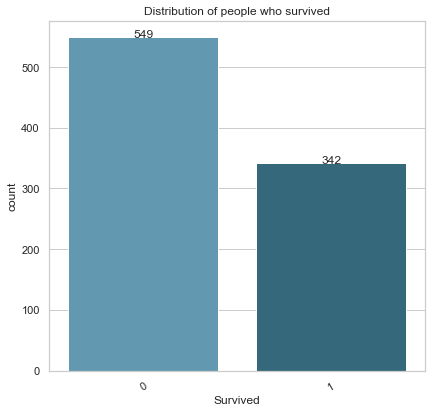

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
graph = sns.countplot(ax=ax,x=train_df['Survived'], data = train_df, palette = 'PuBuGn_d')
graph.set_title('Distribution of people who survived', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Now females have higher probability of survival than males.

Let' check it

In [8]:
train_df.groupby('Survived')['Sex'].value_counts()

Survived  Sex   
0         male      468
          female     81
1         female    233
          male      109
Name: Sex, dtype: int64

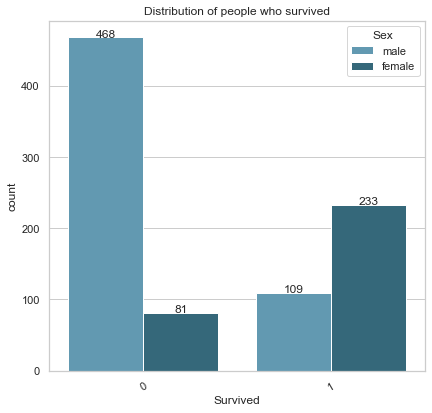

In [9]:
fig, ax = plt.subplots(figsize=(6,6))
graph = sns.countplot(ax=ax,x=train_df['Survived'], data = train_df, hue='Sex', palette = 'PuBuGn_d')
graph.set_title('Distribution of people who survived', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Let's check the percentage of survival for males and females separately.

In [16]:
females = train_df[train_df['Sex'] == 'female']
females.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [17]:
females['Survived'].value_counts()/len(females)

1    0.742038
0    0.257962
Name: Survived, dtype: float64

In [18]:
males = train_df[train_df['Sex'] == 'male']
males.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


In [19]:
males['Survived'].value_counts()/len(males)

0    0.811092
1    0.188908
Name: Survived, dtype: float64

As expected females have higher probability of survival (value 1) 74.20% than males 18.89%.

Let's visualize it.

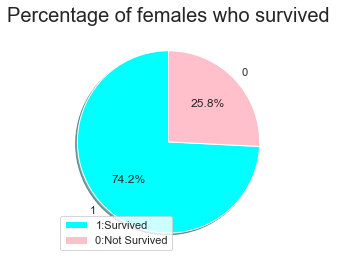

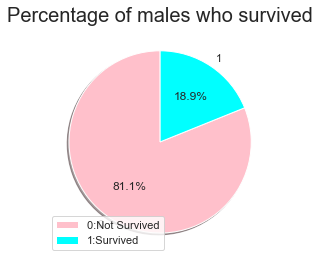

In [20]:
# create the first of two pie-charts and set current axis
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 1)   # (rows, columns, panel number)
labels1 = females['Survived'].value_counts().index
size1 = females['Survived'].value_counts()
colors1=['cyan','pink']
plt.pie(size1, labels = labels1, colors = colors1, shadow = True, autopct='%1.1f%%',startangle = 90)
plt.title('Percentage of females who survived', fontsize = 20)
plt.legend(['1:Survived', '0:Not Survived'], loc=0)
plt.show()

# create the second of two pie-charts and set current axis
plt.figure(figsize=(8,6))
plt.subplot(1, 2, 2)   # (rows, columns, panel number)
labels2 = males['Survived'].value_counts().index
size2 = males['Survived'].value_counts()
colors2=['pink','cyan']
plt.pie(size2, labels = labels2, colors = colors2, shadow = True, autopct='%1.1f%%',startangle = 90)
plt.title('Percentage of males who survived', fontsize = 20)
plt.legend(['0:Not Survived','1:Survived'])
plt.show()

## **5.3 Sex** <a class="anchor" id="5.3"></a>

[Table of Contents](#0.1)


In [21]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

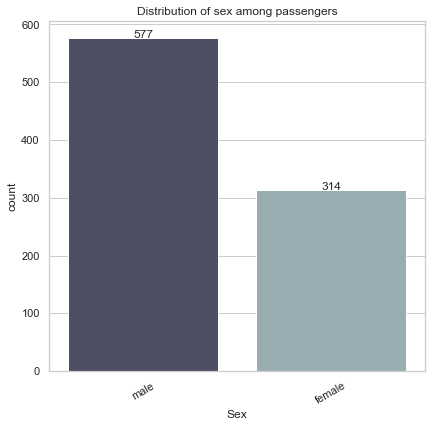

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
graph = sns.countplot(ax=ax,x=train_df['Sex'], data=train_df, palette = 'bone')
graph.set_title('Distribution of sex among passengers', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

In [23]:
train_df['Sex'].value_counts()/len(train_df)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

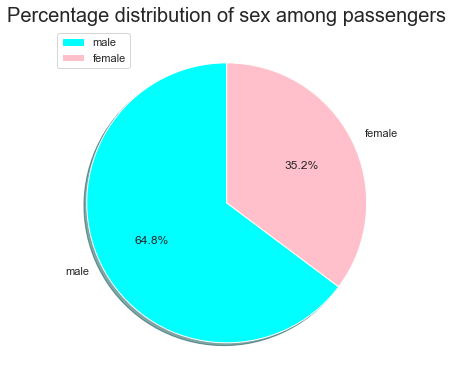

In [24]:
plt.figure(figsize=(8,6))
labels = train_df['Sex'].value_counts().index
size = train_df['Sex'].value_counts()
colors=['cyan','pink']
plt.pie(size, labels = labels, shadow = True, colors=colors, autopct='%1.1f%%',startangle = 90)
plt.title('Percentage distribution of sex among passengers', fontsize = 20)
plt.legend()
plt.show()

## **5.4 Pclass** <a class="anchor" id="5.4"></a>

[Table of Contents](#0.1)


In [25]:
train_df.groupby('Pclass')['Sex'].value_counts()

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

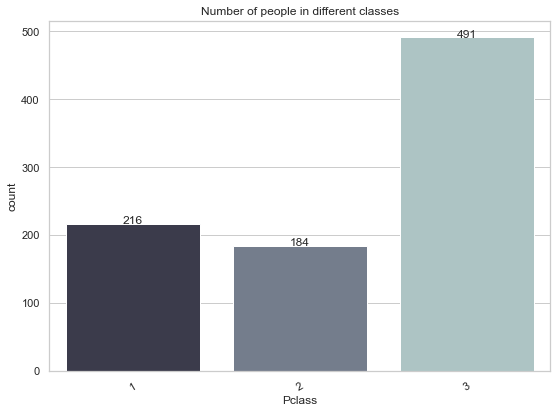

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x=train_df['Pclass'], data=train_df, palette = 'bone')
graph.set_title('Number of people in different classes', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

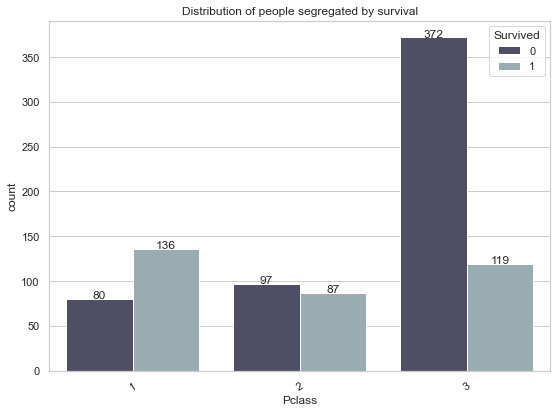

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x=train_df['Pclass'], data=train_df, hue='Survived', palette = 'bone')
graph.set_title('Distribution of people segregated by survival', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Here 0 stands for not survived and 1 stands for survived.

So, we can see that Pclass plays a major role in survival.

Majority of people survived in Pclass 1 while a large number of people do not survive in Pclass 3.

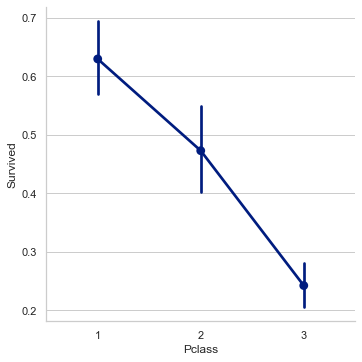

In [28]:
# percentage of survivors per class
sns.factorplot('Pclass', 'Survived', data = train_df)

## **5.5 Embarked** <a class="anchor" id="5.5"></a>

[Table of Contents](#0.1)

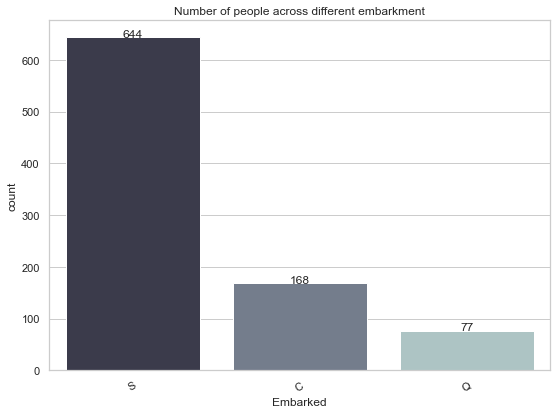

In [29]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x=train_df['Embarked'], data=train_df, palette = 'bone')
graph.set_title('Number of people across different embarkment', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

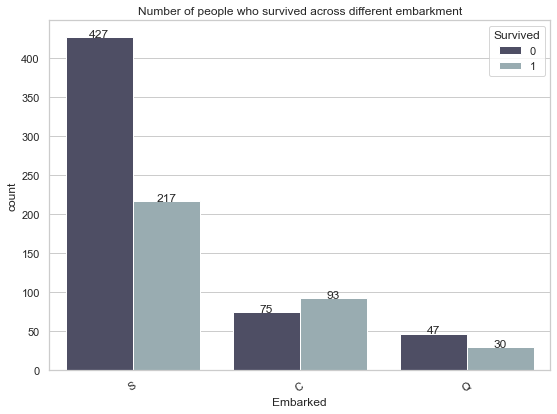

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
graph = sns.countplot(ax=ax,x=train_df['Embarked'], data=train_df, hue='Survived', palette = 'bone')
graph.set_title('Number of people who survived across different embarkment', fontsize = 12)
graph.set_xticklabels(graph.get_xticklabels(),rotation=30)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

We can see that port of embarkment plays a major role in survival probability.

## **5.6 Age** <a class="anchor" id="5.6"></a>

[Table of Contents](#0.1) 

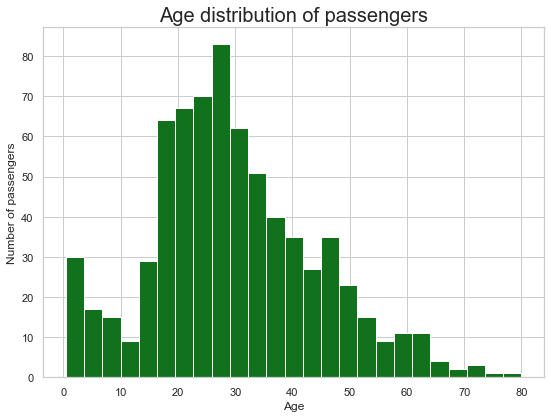

In [31]:
x = train_df['Age']
plt.figure(figsize=(8,6))
plt.hist(x, bins=25, color='g')
plt.xlabel('Age')
plt.ylabel('Number of passengers')
plt.title('Age distribution of passengers', fontsize = 20)
plt.show()

We can see that majority of passengers are aged between 20 and 40.

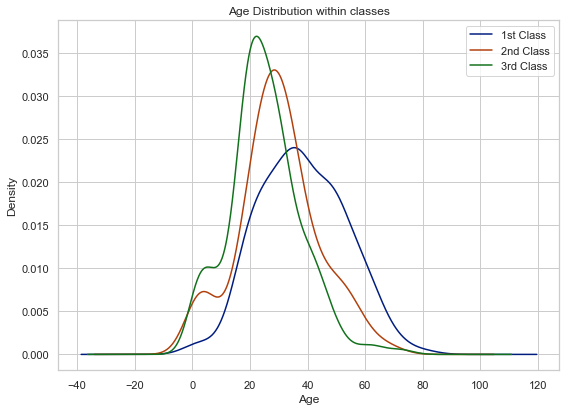

In [32]:
plt.figure(figsize=(8,6))
train_df.Age[train_df.Pclass == 1].plot(kind='kde')    
train_df.Age[train_df.Pclass == 2].plot(kind='kde')
train_df.Age[train_df.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') ;

## **5.7 Visualizations about training set** <a class="anchor" id="5.7"></a>

[Table of Contents](#0.1) 

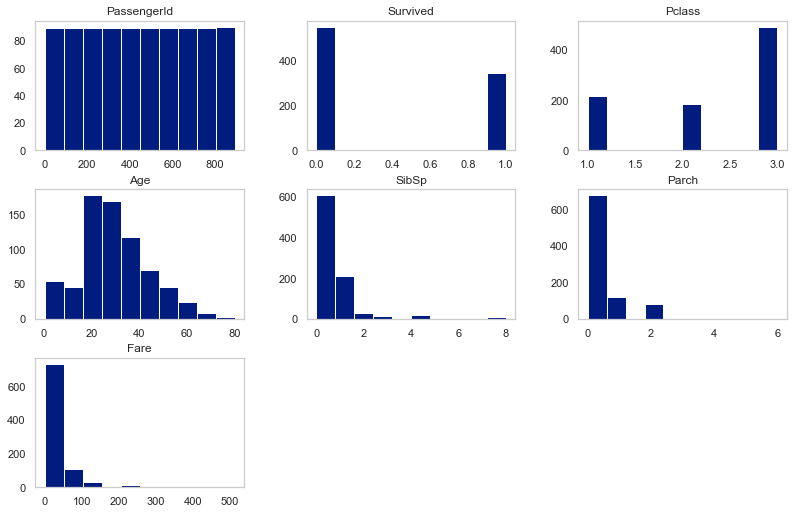

In [33]:
train_df.hist(bins=10,figsize=(12,8),grid=False);

We can see that `Age` and `Fare` are measured on very different scaling. So we need to do feature scaling before predictions.

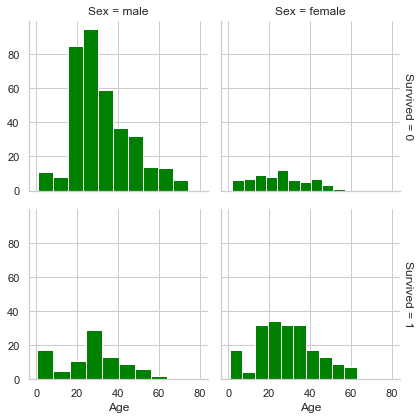

In [34]:
g = sns.FacetGrid(train_df, col="Sex", row="Survived", margin_titles=True)
g.map(plt.hist, "Age", color="green");

## **5.8 Correlation Heatmap** <a class="anchor" id="5.8"></a>

[Table of Contents](#0.1) 

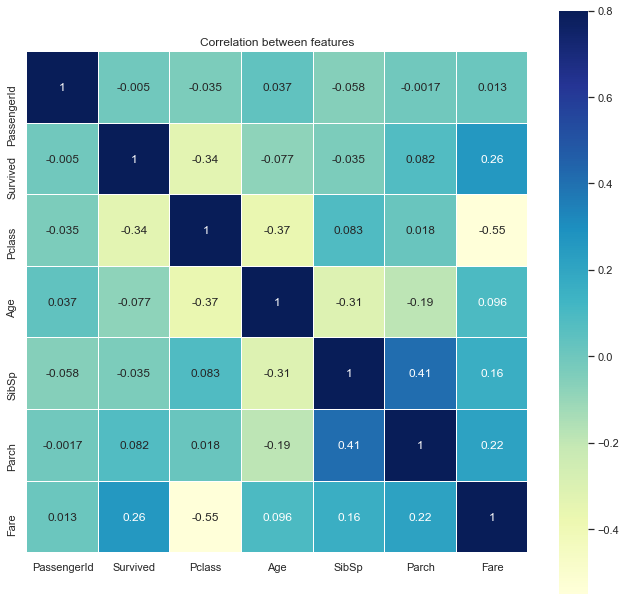

In [35]:
corr = train_df.corr()#["Survived"]
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [36]:
#correlation of features with target variable
train_df.corr()["Survived"]

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

So, `Pclass` has got highest negative correlation with `Survived` and `Fare` has got highest positive correlation with `Survived`.

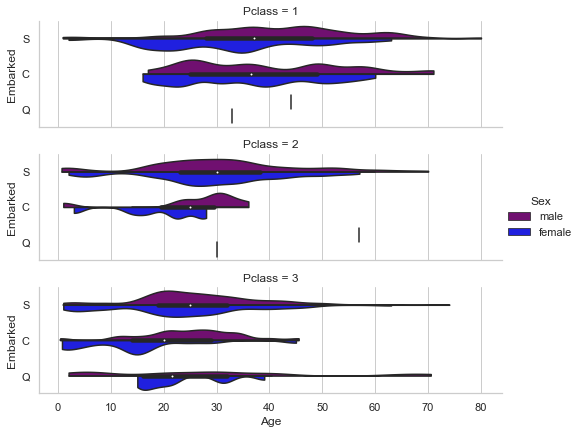

In [37]:
g = sns.factorplot(x="Age", y="Embarked",
                    hue="Sex", row="Pclass",
                    data=train_df[train_df.Embarked.notnull()],
                    orient="h", size=2, aspect=3.5, 
                   palette={'male':"purple", 'female':"blue"},
                    kind="violin", split=True, cut=0, bw=.2);

# **6. Data Preprocessing** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)


## **6.1 Missing Values Imputation** <a class="anchor" id="6.1"></a>

[Table of Contents](#0.1)



It is important to fill missing values, because some machine learning algorithms can't accept them eg SVM.


But filling missing values with mean/median/mode is also a prediction which may not be 100% accurate, instead we can use models like Decision Trees and Random Forest which handle missing values very well.

### **Embarked Column**

In [38]:
#Lets check which rows have null Embarked column
train_df[train_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


**PassengerId** **62** and **830** have missing embarked values. Both have **Passenger class 1** and **fare $80**.


Now, lets plot a graph to visualize and try to guess from where they embarked.

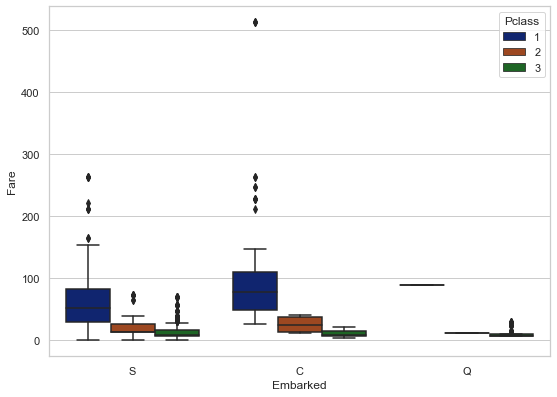

In [39]:
plt.figure(figsize=(8,6))
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=train_df)
plt.show()

We can see that for 1st class median line is coming around fare $80 for embarked value 'C'. So we can replace NA values in Embarked column with 'C'.

In [40]:
train_df["Embarked"] = train_df["Embarked"].fillna('C')

In [41]:
#there is an empty fare column in test set
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### **Fare Column**

In [42]:
test_df[test_df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [43]:
#we can replace missing value in fare by taking median of all fares of those passengers 
#who share 3rd Passenger class and Embarked from 'S' 
def fill_missing_fare(df):
    median_fare=df[(df['Pclass'] == 3) & (df['Embarked'] == 'S')]['Fare'].median()
#'S'
       #print(median_fare)
    df["Fare"] = df["Fare"].fillna(median_fare)
    return df

test_df=fill_missing_fare(test_df)

# **7. Feature Engineering** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)



### **Deck- Where exactly were passenger on the ship?**

In [44]:
train_df["Deck"]=train_df.Cabin.str[0]
test_df["Deck"]=test_df.Cabin.str[0]
train_df["Deck"].unique() # 0 is for null values

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

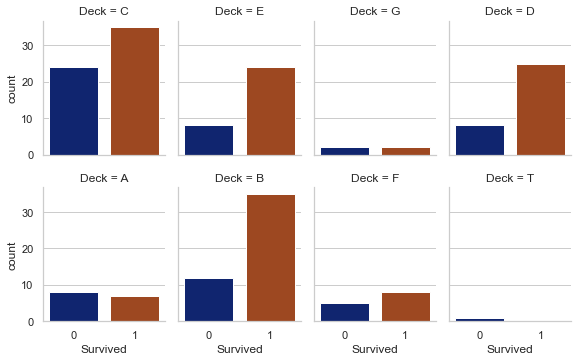

In [45]:
g = sns.factorplot("Survived", col="Deck", col_wrap=4,
                    data=train_df[train_df.Deck.notnull()],
                    kind="count", size=2.5, aspect=.8);

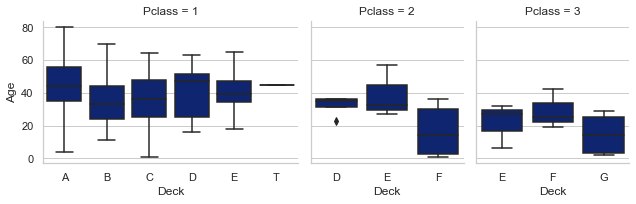

In [46]:
train_df = train_df.assign(Deck=train_df.Deck.astype(object)).sort_values("Deck")
g = sns.FacetGrid(train_df, col="Pclass", sharex=False,
                  gridspec_kws={"width_ratios": [5, 3, 3]})
g.map(sns.boxplot, "Deck", "Age");

In [47]:
train_df.Deck.fillna('Z', inplace=True)
test_df.Deck.fillna('Z', inplace=True)
train_df["Deck"].unique() # Z is for null values

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Z'], dtype=object)

How Big is your family?

In [48]:
# Create a family size variable including the passenger themselves
train_df["FamilySize"] = train_df["SibSp"] + train_df["Parch"]+1
test_df["FamilySize"] = test_df["SibSp"] + test_df["Parch"]+1
print(train_df["FamilySize"].value_counts())

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64


In [49]:
# Discretize family size
train_df.loc[train_df["FamilySize"] == 1, "FsizeD"] = 'singleton'
train_df.loc[(train_df["FamilySize"] > 1)  &  (train_df["FamilySize"] < 5) , "FsizeD"] = 'small'
train_df.loc[train_df["FamilySize"] >4, "FsizeD"] = 'large'

test_df.loc[test_df["FamilySize"] == 1, "FsizeD"] = 'singleton'
test_df.loc[(test_df["FamilySize"] >1) & (test_df["FamilySize"] <5) , "FsizeD"] = 'small'
test_df.loc[test_df["FamilySize"] >4, "FsizeD"] = 'large'


In [50]:
print(train_df["FsizeD"].unique())
print(train_df["FsizeD"].value_counts())

['singleton' 'small' 'large']
singleton    537
small        292
large         62
Name: FsizeD, dtype: int64


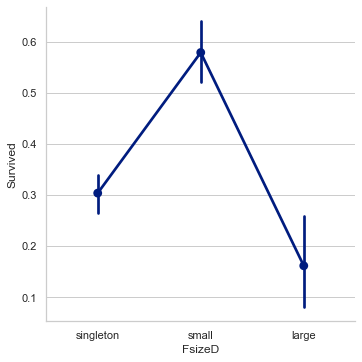

In [51]:
sns.factorplot(x="FsizeD", y="Survived", data=train_df);

### **Do you have longer names?**

In [52]:
#Create feature for length of name 
# The apply method generates a new series

train_df["NameLength"] = train_df["Name"].apply(lambda x: len(x))
test_df["NameLength"] = test_df["Name"].apply(lambda x: len(x))
bins = [0, 20, 40, 57, 85]
group_names = ['short', 'okay', 'good', 'long']
train_df['NlengthD'] = pd.cut(train_df['NameLength'], bins, labels=group_names)
test_df['NlengthD'] = pd.cut(test_df['NameLength'], bins, labels=group_names)


['okay', 'short', 'good', 'long']
Categories (4, object): ['short' < 'okay' < 'good' < 'long']


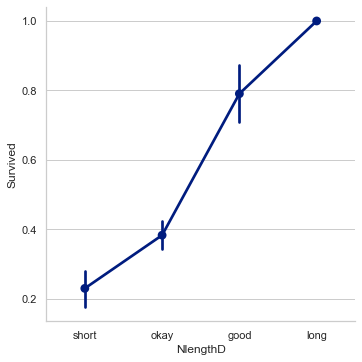

In [53]:
sns.factorplot(x="NlengthD", y="Survived", data=train_df)
print(train_df["NlengthD"].unique())

### **What's in the name?**

In [54]:
import re

#A function to get the title from a name.
def get_title(name):
    """Use a regular expression to search for a title.  
       Titles always consist of capital and lowercase letters, and end with a period"""
    title_search = re.search(' ([A-Za-z]+)\.', name)
    #If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [55]:
#Get all the titles and print how often each one occurs.
titles = train_df["Name"].apply(get_title)
print(pd.value_counts(titles))


Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Sir           1
Ms            1
Capt          1
Don           1
Mme           1
Jonkheer      1
Countess      1
Lady          1
Name: Name, dtype: int64


In [56]:
#Add in the title column.
train_df["Title"] = titles

In [57]:
# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']


In [58]:
# Also reassign mlle, ms, and mme accordingly
train_df.loc[train_df["Title"] == "Mlle", "Title"] = 'Miss'
train_df.loc[train_df["Title"] == "Ms", "Title"] = 'Miss'
train_df.loc[train_df["Title"] == "Mme", "Title"] = 'Mrs'
train_df.loc[train_df["Title"] == "Dona", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Lady", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Countess", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Capt", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Col", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Don", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Major", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Rev", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Sir", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
train_df.loc[train_df["Title"] == "Dr", "Title"] = 'Rare Title'


### **Do the same with test set**

In [59]:
titles = test_df["Name"].apply(get_title)
print(pd.value_counts(titles))

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Name, dtype: int64


In [60]:
#Add in the title column.
test_df["Title"] = titles


In [61]:
# Titles with very low cell counts to be combined to "rare" level
rare_title = ['Dona', 'Lady', 'Countess','Capt', 'Col', 'Don', 
                'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer']

In [62]:
# Also reassign mlle, ms, and mme accordingly
test_df.loc[test_df["Title"] == "Mlle", "Title"] = 'Miss'
test_df.loc[test_df["Title"] == "Ms", "Title"] = 'Miss'
test_df.loc[test_df["Title"] == "Mme", "Title"] = 'Mrs'
test_df.loc[test_df["Title"] == "Dona", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Lady", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Countess", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Capt", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Col", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Don", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Major", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Rev", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Sir", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Jonkheer", "Title"] = 'Rare Title'
test_df.loc[test_df["Title"] == "Dr", "Title"] = 'Rare Title'


In [63]:
test_df["Title"].value_counts()

Mr            240
Miss           79
Mrs            72
Master         21
Rare Title      6
Name: Title, dtype: int64

### **Ticket column**

In [64]:
train_df["Ticket"].tail()

884    SOTON/OQ 392076
885             382652
886             211536
888         W./C. 6607
890             370376
Name: Ticket, dtype: object

In [65]:
train_df["TicketNumber"] = train_df["Ticket"].str.extract('(\d{2,})', expand=True)
train_df["TicketNumber"] = train_df["TicketNumber"].apply(pd.to_numeric)

In [66]:
test_df["TicketNumber"] = test_df["Ticket"].str.extract('(\d{2,})', expand=True)
test_df["TicketNumber"] = test_df["TicketNumber"].apply(pd.to_numeric)

In [67]:
#some rows in ticket column dont have numeric value so we got NaN there
train_df[train_df["TicketNumber"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
772,773,0,2,"Mack, Mrs. (Mary)",female,57.0,0,0,S.O./P.P. 3,10.5,E77,S,E,1,singleton,17,short,Mrs,NaN
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,19,short,Mr,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,28,okay,Mr,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,31,okay,Mr,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Z,1,singleton,19,short,Mr,NaN
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5,NaN,S,Z,1,singleton,24,okay,Mr,NaN


In [68]:
train_df.TicketNumber.fillna(train_df["TicketNumber"].median(), inplace=True)
test_df.TicketNumber.fillna(test_df["TicketNumber"].median(), inplace=True)

# **8. Categorical Encoding** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)

In [69]:
labelenc=LabelEncoder()

cat_vars=['Embarked','Sex',"Title","FsizeD","NlengthD",'Deck']
for col in cat_vars:
    train_df[col]=labelenc.fit_transform(train_df[col])
    test_df[col]=labelenc.fit_transform(test_df[col])

In [70]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,FsizeD,NameLength,NlengthD,Title,TicketNumber
475,476,0,1,"Clifford, Mr. George Quincy",1,NaN,0,0,110465,52.0000,A14,2,0,1,1,27,2,2,110465.0
174,175,0,1,"Smith, Mr. James Clinch",1,56.0,0,0,17764,30.6958,A7,0,0,1,1,23,2,2,17764.0
209,210,1,1,"Blank, Mr. Henry",1,40.0,0,0,112277,31.0000,A31,0,0,1,1,16,3,2,112277.0
445,446,1,1,"Dodge, Master. Washington",1,4.0,0,2,33638,81.8583,A34,2,0,3,2,25,2,0,33638.0
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",1,56.0,0,0,13213,35.5000,A26,0,0,1,1,35,2,4,13213.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",1,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,2,8,1,1,22,2,2,392076.0
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",0,39.0,0,5,382652,29.1250,NaN,1,8,6,0,36,2,3,382652.0
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,2,8,1,1,21,2,4,211536.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,NaN,2,8,4,2,40,2,1,6607.0


### **Age Column**

Age seems to be promising feature. So it doesnt make sense to simply fill null values out with median/mean/mode.

We will use Random Forest algorithm to predict ages.

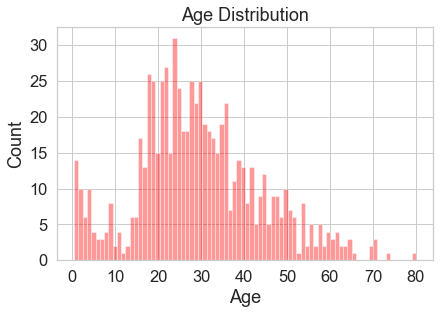

In [71]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(train_df["Age"].dropna(),
                 bins=80,
                 kde=False,
                 color="red")
    plt.title("Age Distribution")
    plt.ylabel("Count");

In [72]:
from sklearn.ensemble import RandomForestRegressor
#predicting missing values in age using Random Forest
def fill_missing_age(df):
    
    #Feature set
    age_df = df[['Age','Embarked','Fare', 'Parch', 'SibSp',
                 'TicketNumber', 'Title','Pclass','FamilySize',
                 'FsizeD','NameLength',"NlengthD",'Deck']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df

In [73]:
train_df=fill_missing_age(train_df)
test_df=fill_missing_age(test_df)

# **9. Feature Scaling** <a class="anchor" id="9"></a>

[Table of Contents](#0.1)


We can see that Age, Fare are measured on different scales, so we need to do Feature Scaling first before we proceed with making predictions with **stacked classifier**.

In [74]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(train_df[['Age', 'Fare']])
train_df[['Age', 'Fare']] = std_scale.transform(train_df[['Age', 'Fare']])


std_scale = preprocessing.StandardScaler().fit(test_df[['Age', 'Fare']])
test_df[['Age', 'Fare']] = std_scale.transform(test_df[['Age', 'Fare']])

### **Correlation of features with target**

In [75]:
train_df.corr()["Survived"]

PassengerId    -0.005007
Survived        1.000000
Pclass         -0.338481
Sex            -0.543351
Age            -0.078609
SibSp          -0.035322
Parch           0.081629
Fare            0.257307
Embarked       -0.174199
Deck           -0.301116
FamilySize      0.016639
FsizeD          0.283810
NameLength      0.332350
NlengthD       -0.312234
Title          -0.071174
TicketNumber   -0.096161
Name: Survived, dtype: float64

# **10. Declare feature vector and target label** <a class="anchor" id="10"></a>

[Table of Contents](#0.1)


In [76]:
# Declare feature vector and target variable
X_train = train_df.drop(labels = ['Survived'],axis = 1)
y_train = train_df['Survived']
X_test = test_df


# **11. Individual Classifiers** <a class="anchor" id="11"></a>

[Table of Contents](#0.1)


For the purpose of illustration, we will train a **Support Vector Classifier (SVC)**, **Multi-layer Perceptron (MLP) classifier**, **Nu-Support Vector classifier (NuSVC)** and a **Random Forest (RF) classifier** — classifiers available in Scikit-learn. 


In [71]:
# Initializing Support Vector classifier
clf_svc = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)

# Initializing Multi-layer perceptron  classifier
clf_mlp = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

# Initialing Nu Support Vector classifier
clf_nusvc = NuSVC(degree = 1, kernel = "rbf", nu = 0.25, probability = True)

# Initializing Random Forest classifier
clf_rfc = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)

# **12. Stacked Classifier** <a class="anchor" id="12"></a>

[Table of Contents](#0.1)


To stack the above classifiers, we will use the [StackingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) from scikit-learn library.


We can also use the [StackingCVClassifier](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/) from MLXTEND for the same purpose. We can take a look at the [official documentation](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/) since it goes in detail over useful examples of how to implement the StackingCVClassifier.


In [72]:
classifiers = [('svc', clf_svc),
               ('mlp', clf_mlp),                             
               ('nusvc', clf_nusvc),
               ('rfc', clf_rfc)]

In [73]:
clf = StackingClassifier(estimators=classifiers, 
                         final_estimator=LogisticRegression(),
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)

In [76]:
predictors=["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD",
              "FsizeD", "Title","Deck","NameLength","TicketNumber"]

clf.fit(X_train[predictors],y_train)

StackingClassifier(estimators=[('svc',
                                SVC(C=50, degree=1, gamma='auto',
                                    probability=True)),
                               ('mlp',
                                MLPClassifier(alpha=0.1,
                                              hidden_layer_sizes=(10, 10, 10),
                                              max_iter=2000,
                                              random_state=1000)),
                               ('nusvc',
                                NuSVC(degree=1, nu=0.25, probability=True)),
                               ('rfc',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=0.005,
                                                       min_samples_split=0.005,
                                                       n_estimators=500,
                                                       n_jobs=-1,
            

In [88]:
test_predictions=clf.predict(X_test[predictors])


In [89]:
test_predictions=test_predictions.astype(int)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": test_predictions
    })

submission.to_csv("titanic_submission.csv", index=False)

In this notebook, we have demonstrated the stacked classifier.

Now we will come to the end of this kernel. I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

Thank you


[Go to Top](#0)

## Fairness 

In [77]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [78]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [79]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [80]:
predictors=["Pclass", "Sex", "Age", "Fare", "Embarked","NlengthD","FsizeD", "Title","Deck","NameLength","TicketNumber", "Survived"]
train_df = train_df[predictors]

train_df

,Pclass,Sex,Age,Fare,Embarked,NlengthD,FsizeD,Title,Deck,NameLength,TicketNumber,Survived
475,1,1,1.174282,0.398582,2,2,1,2,0,27,110465.0,0
174,1,1,1.910591,-0.030371,0,2,1,2,0,23,17764.0,0
209,1,1,0.747357,-0.024246,0,3,1,2,0,16,112277.0,1
445,1,1,-1.869919,0.999770,2,2,2,0,0,25,33638.0,1
647,1,1,1.910591,0.066360,0,2,1,4,0,35,13213.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
884,3,1,-0.343175,-0.506472,2,2,1,2,8,22,392076.0,0
885,3,0,0.674655,-0.061999,1,2,0,3,8,36,382652.0,0
886,2,1,-0.197770,-0.386671,2,2,1,4,8,21,211536.0,0
888,3,0,-1.493969,-0.176263,2,2,2,1,8,40,6607.0,0


In [81]:
#print(X)

#combine_final = [train_df, test_df]
#result = pd.concat(combine_final)
#print(result.ifany())
#print(result)
privileged_groups = [{'Sex': 0}]
unprivileged_groups = [{'Sex': 1}]
dataset_orig = StandardDataset(train_df,
                                  label_name='Survived',
                                  protected_attribute_names=['Sex'],
                                  favorable_classes=[1],
                                  privileged_classes=[[0]])


In [82]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.553130


In [7]:
data_orig_train = pd.read_pickle('../../Results/Stacking/4-stacked-classifier-top-10-on-lb_Train.pkl')
data_orig_test = pd.read_pickle('../../Results/Stacking/4-stacked-classifier-top-10-on-lb_Test.pkl')

In [8]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

import pickle

#data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()


# Initializing Support Vector classifier
clf_svc = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)

# Initializing Multi-layer perceptron  classifier
clf_mlp = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

# Initialing Nu Support Vector classifier
clf_nusvc = NuSVC(degree = 1, kernel = "rbf", nu = 0.25, probability = True)

# Initializing Random Forest classifier
clf_rfc = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                     max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)

estimators = [('svc', clf_svc), ('mlp', clf_mlp), ('nusvc', clf_nusvc), ('rfc', clf_rfc)]

model = StackingClassifier(estimators, 
                         final_estimator=LogisticRegression(),
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)

mdl = model.fit(X_train, y_train)
#with open('../../Results/Stacking/' + nb_fname + '.pkl', 'wb') as f:
#        pickle.dump(mdl, f)

#with open('../../Results/Stacking/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
#    pickle.dump(data_orig_train, f) 
    
#with open('../../Results/Stacking/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
#    pickle.dump(data_orig_test, f) 

In [83]:
final_metrics = []
accuracy = []
f1= []
from statistics import mean
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

for i in range(0,20):
    
    data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
    print(i)
    X_train = data_orig_train.features
    y_train = data_orig_train.labels.ravel()

    X_test = data_orig_test.features
    y_test = data_orig_test.labels.ravel()
    # Initializing Support Vector classifier
    clf_svc = SVC(C = 50, degree = 1, gamma = "auto", kernel = "rbf", probability = True)

    # Initializing Multi-layer perceptron  classifier
    clf_mlp = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)

    # Initialing Nu Support Vector classifier
    clf_nusvc = NuSVC(degree = 1, kernel = "rbf", nu = 0.25, probability = True)

    # Initializing Random Forest classifier
    clf_rfc = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                                         max_features = "auto", min_samples_leaf = 0.005,
                                     min_samples_split = 0.005, n_jobs = -1, random_state = 1000)

    estimators = [('svc', clf_svc), ('mlp', clf_mlp), ('nusvc', clf_nusvc), ('rfc', clf_rfc)]

    model = StackingClassifier(estimators, 
                         final_estimator=LogisticRegression(),
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)
  
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)

element_wise_std =  np.std(final_metrics, 0, ddof=1)
print("STD " + str(element_wise_std))
final_metrics = list(map(mean, zip(*final_metrics)))
accuracy = mean(accuracy)
f1 = mean(f1)
final_metrics[4] = np.log(final_metrics[4])
print(final_metrics)
print(sum(final_metrics[1:]))
print(accuracy)
print(f1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
STD [5.91607978 0.05471324 0.11070528 0.08221904 0.02689041 0.0219144 ]
[9.5, -0.7203523038055866, -0.5864261864399819, 0.5217031590566223, -2.2642417945241333, 0.12984883983106893]
-2.9194682858820102
0.839365671641791
0.774394999521829


In [22]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
list_estimators = []
f1= []

for name, ml_model in estimators:
    
    list_estimators.append((name,ml_model))
    print(list_estimators)
    model = StackingClassifier(estimators = list_estimators, final_estimator=LogisticRegression())
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


[('svc', SVC(C=50, degree=1, gamma='auto', probability=True))]
[('svc', SVC(C=50, degree=1, gamma='auto', probability=True)), ('mlp', MLPClassifier(alpha=0.1, hidden_layer_sizes=(10, 10, 10), max_iter=2000,
              random_state=1000))]
[('svc', SVC(C=50, degree=1, gamma='auto', probability=True)), ('mlp', MLPClassifier(alpha=0.1, hidden_layer_sizes=(10, 10, 10), max_iter=2000,
              random_state=1000)), ('nusvc', NuSVC(degree=1, nu=0.25, probability=True))]
[('svc', SVC(C=50, degree=1, gamma='auto', probability=True)), ('mlp', MLPClassifier(alpha=0.1, hidden_layer_sizes=(10, 10, 10), max_iter=2000,
              random_state=1000)), ('nusvc', NuSVC(degree=1, nu=0.25, probability=True)), ('rfc', RandomForestClassifier(max_depth=10, min_samples_leaf=0.005,
                       min_samples_split=0.005, n_estimators=500, n_jobs=-1,
                       random_state=1000))]


In [9]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
list_estimators = []
f1= []

for name, ml_model in estimators:
    
    list_estimators.append((name,ml_model))
    print(list_estimators)
    model = ml_model
    list_estimators = []
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


[('svc', SVC(C=50, degree=1, gamma='auto', probability=True))]
[('mlp', MLPClassifier(alpha=0.1, hidden_layer_sizes=(10, 10, 10), max_iter=2000,
              random_state=1000))]
[('nusvc', NuSVC(degree=1, nu=0.25, probability=True))]
[('rfc', RandomForestClassifier(max_depth=10, min_samples_leaf=0.005,
                       min_samples_split=0.005, n_estimators=500, n_jobs=-1,
                       random_state=1000))]


In [10]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[3] = np.log(final_result[3])
final_result = final_result.transpose()
acc_f1 = pd.DataFrame(accuracy)
acc_f1['f1'] = f1
acc_f1 = pd.DataFrame(acc_f1).transpose()
acc = acc_f1.rename(index={0: 'accuracy', 1: 'f1'})
final_result = final_result.rename(index={0: 'statistical_parity_difference', 1: 'equal_opportunity_difference', 2: 'average_abs_odds_difference', 3: 'disparate_impact', 4: 'theil_index'})
final_result = pd.concat([acc,final_result])
#final_result.columns = ['T' + str(col) for col in final_result.columns]
#final_result.insert(0, "classifier", final_result['T' + str(len(list_estimators) - 1)])   ##Add final metrics add the beginning of the df
#final_result.to_csv('../../Results/Stacking/' + nb_fname + '.csv')
final_result

,0,1,2,3
accuracy,0.660448,0.589552,0.511194,0.824627
f1,0.315789,0.408602,0.469636,0.756477
statistical_parity_difference,-0.040161,-0.148240,-0.065674,-0.786676
equal_opportunity_difference,0.080000,-0.054286,-0.014286,-0.662857
average_abs_odds_difference,0.042770,0.126766,0.038060,0.645369
disparate_impact,-0.275706,-0.421057,-0.114340,-2.555028
theil_index,0.350821,0.293347,0.208121,0.116755
